# Reconhecimento de Batidas (Snooooop)

**Objetivos**
1. Entender a diversidade musical em rap ao longo dos anos

**Resultado Esperado**
1. Implementar um algoritmo de extração de batidas
1. Saber usar o librosa para extrair batidas
   1. Não precisamos fazer tudo do zero
1. Usar DTW para comparar as batidas

In [1]:
from numba import jit

import glob

import librosa
import librosa.display

import IPython.display as ipd

import matplotlib.pyplot as plt

import numpy as np
import os
import pandas as pd

plt.rcParams['axes.labelsize']  = 16
plt.rcParams['axes.titlesize']  = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['lines.linewidth'] = 2

plt.ion()

## O problema

Neste notebook vamos tentar entender se o [Snoop Dogg](https://pt.wikipedia.org/wiki/Snoop_Dogg) tem razão quando fala que o Rap vem ficando sempre igual. Observe na fala do Snoop como ele fala que as batidas do Rap vem ficando cada vez mais homogêneas.

In [2]:
from IPython.display import Video
Video('https://pudding.cool/2018/05/similarity/assets/videos/video_snoop.mp4')

Este laboratório foi motivado pelo artifo do [Pudding Cool](https://pudding.cool/2018/05/similarity/) que levanta evidências de que a música **pop** no geral vem ficando cada vez mais similar. Recomendo uma leitura do artigo antes de continuar, vamos seguir uma sequência de passos parecida. Portanto, vamos comparar músicas lançadas em anos diferentes. A nossa comparação vai ser feita com base na série de novelty extraídas pelo [librosa](https://librosa.org/). 

Para entender como extrair novidade usando librosa, use este [notebook](https://musicinformationretrieval.com/novelty_functions.html) como exemplo. Além do mais, você pode refrescar seu conhecimento da aula usando os [FMP Notebooks](https://www.audiolabs-erlangen.de/resources/MIR/FMP/C6/C6.html).

Para ilustrar os dados que faremos uso, a figura abaixo mostra um exemplo do Librosa extraindo **curvas** de batidas com dois métodos diferentes. Em particular estamos comparando o [Onset Strength](https://www.audiolabs-erlangen.de/resources/MIR/FMP/C6/C6S1_OnsetDetection.html) e o [Predominant Local Pulse](https://www.audiolabs-erlangen.de/resources/MIR/FMP/C6/C6S3_PredominantLocalPulse.html).

![](https://librosa.org/doc/latest/_images/librosa-beat-plp-1_01.png)

Agora, imagine uma base de dados de músicas por ano. Cada música vai ter uma, ou várias, **curvas** de novidade. Com tal base você deve gerar o seguinte plot:
1. Para cada tipo de novidade (use as do librosa ou implemente as suas)
   1. Ordenar as músicas no tempo
   1. Da última (mais recente) até a primeira
       1. Caminhar para trás
       1. Tirar a similaridade. Aqui você pode usar Dynamic Time Warping.
       1. Plotar
   1. Agregar o plot acima por década de lançamento
   
``` 
essa curva é a sim média de tudo lançando entre 2010~2019. cada ponto é a média da década com década antes
    |
    v
| x x x x  
|         x 
|           x 
|            x                 o o o o o o o o o <- essa é a curva para os anos 2000 por exemplo
|             x
|              x x x x x x x x x x x x x x x x x
 -----------------------------------------------
 2019 aqui                            2010 aqui
   ano lançamento
```
   5. O formato da curva mostra o quão diverso foi a década
   
Este é o lab!

## Base de Dados

Para resolver nosso problema, vamos inicialmente pegar as músicas do estilo RAP dos últimos anos da Billboard. Para tal, faremos uso [desta](https://www.kaggle.com/danield2255/data-on-songs-from-billboard-19992019) base de dados. Abaixo tenho uma leitura da base.

In [3]:
df = pd.read_csv('billboardHot100_1999-2019.csv.zip', index_col=0)
df['Date'] = pd.to_datetime(df['Date'])
df['Week'] = pd.to_datetime(df['Week'])
df.head()

,Artists,Name,Weekly.rank,Peak.position,Weeks.on.chart,Week,Date,Genre,Writing.Credits,Lyrics,Features
1,"Lil Nas,",Old Town Road,1,1.0,7.0,2019-07-06,2019-04-05,"Country,Atlanta,Alternative Country,Hip-Hop,Tr...","Jozzy, Atticus ross, Trent reznor, Billy ray c...","Old Town Road Remix \nOh, oh-oh\nOh\nYeah, I'm...",Billy Ray Cyrus
2,"Shawn Mendes, Camila Cabello",Senorita,2,NaN,NaN,2019-07-06,2019-06-21,Pop,"Cashmere cat, Jack patterson, Charli xcx, Benn...",Senorita \nI love it when you call me senorita...,NaN
3,Billie Eilish,Bad Guy,3,2.0,13.0,2019-07-06,2019-03-29,"Hip-Hop,Dark Pop,House,Trap,Memes,Alternative ...","Billie eilish, Finneas","bad guy \nWhite shirt now red, my bloody nose\...",NaN
4,Khalid,Talk,4,3.0,20.0,2019-07-06,2019-02-07,"Synth-Pop,Pop","Howard lawrence, Guy lawrence, Khalid",Talk \nCan we just talk? Can we just talk?\nTa...,NaN
5,"Ed Sheeran, Justin Bieber",I Don't Care,5,2.0,7.0,2019-07-06,2019-05-10,"Canada,UK,Dance,Dance-Pop,Pop","Ed sheeran, Justin bieber, Shellback, Max mart...",I Don't Care \nI'm at a party I don't wanna be...,NaN


Vamos remover as colunas que não importam.

In [4]:
df = df.drop(['Writing.Credits',
              'Lyrics',
              'Features',
              'Weekly.rank', 
              'Peak.position',
              'Weeks.on.chart',
             ],
             axis='columns')
df.head()

,Artists,Name,Week,Date,Genre
1,"Lil Nas,",Old Town Road,2019-07-06,2019-04-05,"Country,Atlanta,Alternative Country,Hip-Hop,Tr..."
2,"Shawn Mendes, Camila Cabello",Senorita,2019-07-06,2019-06-21,Pop
3,Billie Eilish,Bad Guy,2019-07-06,2019-03-29,"Hip-Hop,Dark Pop,House,Trap,Memes,Alternative ..."
4,Khalid,Talk,2019-07-06,2019-02-07,"Synth-Pop,Pop"
5,"Ed Sheeran, Justin Bieber",I Don't Care,2019-07-06,2019-05-10,"Canada,UK,Dance,Dance-Pop,Pop"


Agora, vou pegar os gêneros musicais de cada música da billboard. Esyte código é mais por curiosidade, fiz a escolha das `strings` que representam Rap com base nele.

In [5]:
genres = set()
for _, row in df.iterrows():
    genres.update(set(row['Genre'].split(',')))

In [6]:
print('\n'.join(sorted(genres)))

A Cappella
Acoustic
Adult Alternative
Adult Contemporary
African Languages
Afro Trap
Afrobeats
Alternative
Alternative Country
Alternative Dance
Alternative Metal
Alternative Pop
Alternative R&;B
Alternative Rock
Ambient
American Idol
American Underground
Americana
Anime
Art Pop
Art Rock
Atlanta
Aussie Hip-Hop
Australia
Avant Garde
Bachata
Ballad
Baroque Pop
Basketball
Bass Music
Bassline
Bay Area
Bedroom Pop
Beef
Big Band
Blue-Eyed Soul
Bluegrass
Blues
Blues Rock
Bolivia
Boom Bap
Bossa Nova
Bounce
Boy Band
Brasil
Brit Pop
British Rock
Broadway
Bubblegum Pop
Calypso
Canada
Celtic
Chamber Music
Charity
Chart History
Chicago Drill
Children&#39;s Music
Chill
Chillhop
Chillstep
Christian
Christian Metal
Christian Pop
Christian Rock
Christmas
Civil Rights
Classical Crossover
Classical Music
Climate Change
Cloud Rap
Colombia
Comedy
Conscious Hip-Hop
Contemporary Folk
Country
Country Rap
Cover
Crunk
Cuba
DMV
Dab
Dance
Dance-Pop
Dancehall
Danmark
Dark Ambient
Dark Pop
Deep House
Deutscher Rap


Vamos filtrar as músicas de Rap, Hip-Hop, R&B, Funk etc

In [7]:
hip = df['Genre'].str.contains('Hip-Hop')
rap = df['Genre'].str.contains('Rap')
rb = df['Genre'].str.contains('R&;B')
funk = df['Genre'].str.contains('Funk')

# Acaha que fiquei só com Rap, mas pode brincar se quiser. Fiz isso por tamanho da base.
df = df[rap]
df = df.drop('Genre', axis='columns')
df.head()

,Artists,Name,Week,Date
1,"Lil Nas,",Old Town Road,2019-07-06,2019-04-05
7,DaBaby,Suge,2019-07-06,2019-03-01
8,Drake,Money In The Grave,2019-07-06,2019-06-15
9,Chris Brown,No Guidance,2019-07-06,2019-06-08
10,Post Malone,Wow.,2019-07-06,2018-12-24


Vamos ver o tamanho do dataset final

In [8]:
df.shape

(30695, 4)

Ok, agora vamos usar um group by para pegar a quantidade de semanas que uma música ocorre. Vamos focar nas músicas que aparecem em pelo menos 21 semanas (aproximadamente 6 meses). Assim ficamos com um conjunto pequeno de dados.

Outro motivo para tal escolha é ter pelo menos umas 10 músicas por ano, como mostramos a seguir. O primeiro e último ano podem ser ignorados.

In [9]:
songs = df.groupby(['Artists', 'Name']).count()['Week'].sort_values()
songs

Artists               Name                
Sean Kingston         Dumb Love                1
Plies                 Real Hitta               1
Frank Ocean           Chanel                   1
Curren$Y              Bottom Of The Bottle     1
Plies                 Want It, Need It         1
                                              ..
Maroon 5              Girls Like You          52
Florida Georgia Line  Cruise                  54
The Black Eyed Peas   I Gotta Feeling         56
Katy Perry            Dark Horse              57
Shirt                 T                       62
Name: Week, Length: 2473, dtype: int64

Pega a data da primeira entrada na billboard

In [10]:
year = df.groupby(['Artists', 'Name']).min()['Week'].sort_values()

Pega as músicas mais populares


In [11]:
songs = songs[songs >= 21]
songs

Artists               Name                     
Destiny's Child       Soldier                      21
Jason Derulo          Wiggle                       21
Drake                 Find Your Love               21
Kendrick Lamar        Bitch, Don't Kill My Vibe    21
Lil Wayne             She Will                     21
                                                   ..
Maroon 5              Girls Like You               52
Florida Georgia Line  Cruise                       54
The Black Eyed Peas   I Gotta Feeling              56
Katy Perry            Dark Horse                   57
Shirt                 T                            62
Name: Week, Length: 458, dtype: int64

In [12]:
from collections import Counter
years = []
for y in year[songs.index]:
    years.append(y.year)
Counter(years)

Counter({2004: 23,
         2014: 23,
         2010: 26,
         2013: 18,
         2011: 25,
         2002: 21,
         2003: 25,
         2009: 25,
         2017: 36,
         2000: 12,
         2008: 23,
         2018: 33,
         2001: 15,
         2016: 28,
         2006: 20,
         2005: 27,
         2015: 25,
         2007: 23,
         2012: 24,
         2019: 4,
         1999: 2})

### YTMDL

Por fim, baixei as músicas usando o [YTMDL](https://github.com/deepjyoti30/ytmdl). Esta ferramenta permite a busca por músicas no YouTube fazendo uso do nome de título da mesma. Algumas opções do script:

1. -q pedir nada para o usuário
1. --choice pegar a primeira música
1. --nolocal não usar cache
1. --artist nome do artist
1. --skip-meta ignora meta dados, muitos erros
1. --disable-metaadd nem usa metadados para nada, melhorou os resultados
1. --ignore-errors, pule as músicas que não acha

O argumento sem nome é o nome da música. Coloquei tudo em um script e mandei executar para baixar as músicas.

In [13]:
# O código abaixo prepara para baixar as músicas usando o https://github.com/deepjyoti30/ytmdl
# Pode ignorar
with open('yolo.txt', 'w') as yolo:
    for artist, name in songs.index.to_flat_index():
        print(artist,
              name,
              year.loc[artist].loc[name].year,
              file=yolo)
! head yolo.txt

Destiny's Child Soldier 2004
Jason Derulo Wiggle 2014
Drake Find Your Love 2010
Kendrick Lamar Bitch, Don't Kill My Vibe 2013
Lil Wayne She Will 2011
P. Diddy I Need A Girl 2002
Chingy Holidae In 2003
Cam'Ron Hey Ma 2002
Sean Kingston Fire Burning 2009
Mario Just A Friend 2002 2002


In [14]:
# as músicas foram baixadas com o comando
# ytmdl --list yolo.txt --skip-meta -q --disable-metaadd --level DEBUG --ignore-errors

## Navegando as MP3s

Lembre-se que o módulo glob permite caminhar em arquivos

In [15]:
mp3fpaths = glob.glob('files/*.mp3')[:2]
print("\n".join(mp3fpaths))

files/Jeremih - Down On Me ft. 50 Cent (Official Music Video).mp3
files/Mario - Just A Friend 2002 (Nickelodeon Video Version).mp3


Processei o log do ytmdl para pegar o nome do arquivo com ano. Observe acima como coloquei o ano na query, o log tem entradas como:

`song_name:  Shirts... And Pants. Pants Pants Pants Pants.  song_meta:  Shirt T 2008`

Aqui o song_meta foi minha query. Com isso consigo pegar os anos das mp3s.

In [16]:
nome_ano = pd.read_csv('./arquivo_ano.tsv', sep='\t', names=['file_exists', 'fpath', 'year'])
nome_ano

,file_exists,fpath,year
0,True,files/2003 - Freek de Jonge - De Stemming 1 - ...,2003
1,True,files/21. El Perdón - Nicky Jam y Enrique Igle...,2015
2,True,files/21 Savage - a lot (Official Video) ft. J...,2019
3,True,files/21 Savage - Bank Account (Official Audio...,2017
4,True,files/21 Savage & Metro Boomin - X ft Future (...,2016
...,...,...,...
447,True,files/Yo Gotti - Rake It Up ft. Nicki Minaj.mp3,2017
448,True,files/YoungBloodZ - Damn! (Video) ft. Lil' Jon...,2003
449,True,files/Young Money - Bed Rock (Official Music V...,2009
450,True,files/Yung Joc - It's Goin Down (Official Musi...,2006


In [17]:
Counter(nome_ano['year'])

Counter({2003: 25,
         2015: 24,
         2019: 4,
         2017: 36,
         2016: 28,
         2013: 18,
         2012: 24,
         2008: 23,
         2005: 27,
         2004: 22,
         2018: 33,
         2006: 20,
         2001: 15,
         2014: 23,
         2002: 20,
         2007: 22,
         2011: 25,
         2010: 24,
         2009: 25,
         2000: 12,
         1999: 2})

Temos uma quantidade boa de dados!

## Sua Solução

A partir daqui.

In [18]:
import warnings
warnings.filterwarnings('ignore')

In [30]:
year_sorted_songs = nome_ano.sort_values('year', ascending=False)
year_sorted_songs.iloc[0]["fpath"]

'files/21 Savage - a lot (Official Video) ft. J. Cole.mp3'

In [31]:
def get_song_beat_pulse(index):
    song = year_sorted_songs.iloc[index]
    song_wv, sr = librosa.load(song["fpath"], offset=60)
    onset_env = librosa.onset.onset_strength(y=song_wv, sr=sr)
    pulse = librosa.beat.plp(onset_envelope=onset_env, sr=sr)
    print('Calculating sound waves for ', index, song["fpath"], song["year"])
        
    return pulse

def calculate_back_similarity():
    back_similarities = []
    
    base_song = get_song_beat_pulse(0)
    for i in range(len(year_sorted_songs)):
        print('Calculated back similarity for ', i)
        song_pulse = get_song_beat_pulse(i)
        D, _ = librosa.sequence.dtw(base_song, song_pulse, subseq=True)
        similarity_sum = D[-1][-1]
        back_similarities.append(similarity_sum)
        
    return back_similarities


back_similarities = calculate_back_similarity()

Calculating sound waves for  0 files/21 Savage - a lot (Official Video) ft. J. Cole.mp3 2019
Calculated back similarity for  0
Calculating sound waves for  0 files/21 Savage - a lot (Official Video) ft. J. Cole.mp3 2019
Calculated back similarity for  1
Calculating sound waves for  1 files/J. Cole - MIDDLE CHILD.mp3 2019
Calculated back similarity for  2
Calculating sound waves for  2 files/Mustard, Migos - Pure Water.mp3 2019
Calculated back similarity for  3
Calculating sound waves for  3 files/Post Malone - "Wow." (Official Music Video).mp3 2019
Calculated back similarity for  4
Calculating sound waves for  4 files/Post Malone - Psycho ft. Ty Dolla $ign.mp3 2018
Calculated back similarity for  5
Calculating sound waves for  5 files/Migos - Walk It Talk It ft. Drake (Official Video).mp3 2018
Calculated back similarity for  6
Calculating sound waves for  6 files/Gucci Mane, Bruno Mars, Kodak Black - Wake Up in The Sky [Official Music Video].mp3 2018
Calculated back similarity for  7
C

Calculated back similarity for  63
Calculating sound waves for  63 files/Ayo & Teo - Rolex (Official Video).mp3 2017
Calculated back similarity for  64
Calculating sound waves for  64 files/NF - Let You Down.mp3 2017
Calculated back similarity for  65
Calculating sound waves for  65 files/N.E.R.D & Rihanna - Lemon.mp3 2017
Calculated back similarity for  66
Calculating sound waves for  66 files/Post Malone - rockstar ft. 21 Savage.mp3 2017
Calculated back similarity for  67
Calculating sound waves for  67 files/DJ Khaled - Wild Thoughts (Official Video) ft. Rihanna, Bryson Tiller.mp3 2017
Calculated back similarity for  68
Calculating sound waves for  68 files/Lil Uzi Vert - The Way Life Goes [Official Visualizer].mp3 2017
Calculated back similarity for  69
Calculating sound waves for  69 files/Migos Slippery Live Lollapolaza.mp3 2017
Calculated back similarity for  70
Calculating sound waves for  70 files/Lil Uzi Vert - XO Tour Llif3 (Official Music Video).mp3 2017
Calculated back sim

Calculated back similarity for  127
Calculating sound waves for  127 files/MKTO - Classic (Official Video).mp3 2014
Calculated back similarity for  128
Calculating sound waves for  128 files/Big Sean - I Don't Fuck With You ft. E-40 (Official Music Video).mp3 2014
Calculated back similarity for  129
Calculating sound waves for  129 files/Bobby Shmurda - Hot N*gga (Official Music Video).mp3 2014
Calculated back similarity for  130
Calculating sound waves for  130 files/Nicki Minaj - Only ft. Drake, Lil Wayne, Chris Brown.mp3 2014
Calculated back similarity for  131
Calculating sound waves for  131 files/Pitbull, Ne-Yo - Time Of Our Lives (Official Video).mp3 2014
Calculated back similarity for  132
Calculating sound waves for  132 files/Jason Derulo - Talk Dirty (DWTS 2014).mp3 2014
Calculated back similarity for  133
Calculating sound waves for  133 files/Chris Brown - New Flame (Official Video) ft. Usher, Rick Ross.mp3 2014
Calculated back similarity for  134
Calculating sound waves f

Calculated back similarity for  188
Calculating sound waves for  188 files/2 Chainz - No Lie ft. Drake (Official Music Video) (Explicit Version).mp3 2012
Calculated back similarity for  189
Calculating sound waves for  189 files/Alicia Keys - Girl On Fire (Live from iTunes Festival, London, 2012).mp3 2012
Calculated back similarity for  190
Calculating sound waves for  190 files/Pitbull - Give Me Everything.mp3 2011
Calculated back similarity for  191
Calculating sound waves for  191 files/Tyga - Rack City (Official Music Video) (Explicit).mp3 2011
Calculated back similarity for  192
Calculating sound waves for  192 files/Wiz Khalifa - Roll Up [Official Music Video].mp3 2011
Calculated back similarity for  193
Calculating sound waves for  193 files/The Black Eyed Peas - Just Can't Get Enough (Official Music Video).mp3 2011
Calculated back similarity for  194
Calculating sound waves for  194 files/Snoop Dogg & Wiz Khalifa - Young, Wild and Free ft. Bruno Mars [Official Video].mp3 2011
C

Calculated back similarity for  248
Calculating sound waves for  248 files/The Black Eyed Peas - I Gotta Feeling (Official Music Video).mp3 2009
Calculated back similarity for  249
Calculating sound waves for  249 files/How Low.mp3 2009
Calculated back similarity for  250
Calculating sound waves for  250 files/The Black Eyed Peas - Imma Be (Official Music Video).mp3 2009
Calculated back similarity for  251
Calculating sound waves for  251 files/Jay Z & Alicia Keys - Empire State of Mind - Live Amercian Music Awards 2009.mp3 2009
Calculated back similarity for  252
Calculating sound waves for  252 files/PITBULL - I know you want me (calle ocho) [Official video HD].mp3 2009
Calculated back similarity for  253
Calculating sound waves for  253 files/Soulja Boy Tell'em ft. Sammie - Kiss Me Thru The Phone (Official Video).mp3 2009
Calculated back similarity for  254
Calculating sound waves for  254 files/Pitbull - Hotel Room Service.mp3 2009
Calculated back similarity for  255
Calculating so

Calculated back similarity for  309
Calculating sound waves for  309 files/JoJo  - Too Little Too Late (Official Music Video) "The High Road" first hit single.mp3 2006
Calculated back similarity for  310
Calculating sound waves for  310 files/Field Mob - So What ft. Ciara (Official Video).mp3 2006
Calculated back similarity for  311
Calculating sound waves for  311 files/Jim Jones - We Fly High (Official Video).mp3 2006
Calculated back similarity for  312
Calculating sound waves for  312 files/Akon ft. Snoop Dogg - I Wanna Love You (Official Video).mp3 2006
Calculated back similarity for  313
Calculating sound waves for  313 files/Yung Joc - It's Goin Down (Official Music Video).mp3 2006
Calculated back similarity for  314
Calculating sound waves for  314 files/Pussycat Dolls - Buttons Live At  American Music Awards 2006.mp3 2006
Calculated back similarity for  315
Calculating sound waves for  315 files/Fergie - Fergalicious (Official Music Video).mp3 2006
Calculated back similarity fo

Calculated back similarity for  370
Calculating sound waves for  370 files/Beenie Man feat. Ms. Thing & Shawnna - Dude [Remix] (2004).mp3 2004
Calculated back similarity for  371
Calculating sound waves for  371 files/Trick Daddy feat. Lil Jon & Twista - Let's Go (Official Video) [Explicit].mp3 2004
Calculated back similarity for  372
Calculating sound waves for  372 files/OutKast - Roses (Official Video).mp3 2004
Calculated back similarity for  373
Calculating sound waves for  373 files/Christina Milian - Dip It Low (Official Music Video).mp3 2004
Calculated back similarity for  374
Calculating sound waves for  374 files/Nelly - Over And Over (Official Music Video) ft. Tim McGraw.mp3 2004
Calculated back similarity for  375
Calculating sound waves for  375 files/N.O.R.E., Nina Sky, Daddy Yankee - Oye Mi Canto (Official Video) HD.mp3 2004
Calculated back similarity for  376
Calculating sound waves for  376 files/Alicia Keys - Diary (Live) ft. Tony! Toni! Tone!, Jermaine Paul.mp3 2004
C

Calculating sound waves for  431 files/Missy Elliott - Get Ur Freak On [Official Music Video].mp3 2001
Calculated back similarity for  432
Calculating sound waves for  432 files/Missy Elliott - One Minute Man (feat. Ludacris) [Official Music Video].mp3 2001
Calculated back similarity for  433
Calculating sound waves for  433 files/Mr.Cheeks - Lights, Camera, Action! (Official Music Video).mp3 2001
Calculated back similarity for  434
Calculating sound waves for  434 files/Nelly - Ride Wit Me (Live).mp3 2001
Calculated back similarity for  435
Calculating sound waves for  435 files/R. Kelly - Fiesta (Remix) ft. Jay-Z, Boo, Gotti.mp3 2001
Calculated back similarity for  436
Calculating sound waves for  436 files/Eve ft. Gwen Stefani - Let Me Blow Ya Mind (Official Video).mp3 2001
Calculated back similarity for  437
Calculating sound waves for  437 files/Always On Time.mp3 2001
Calculated back similarity for  438
Calculating sound waves for  438 files/faded soul dicision.mp3 2000
Calculate

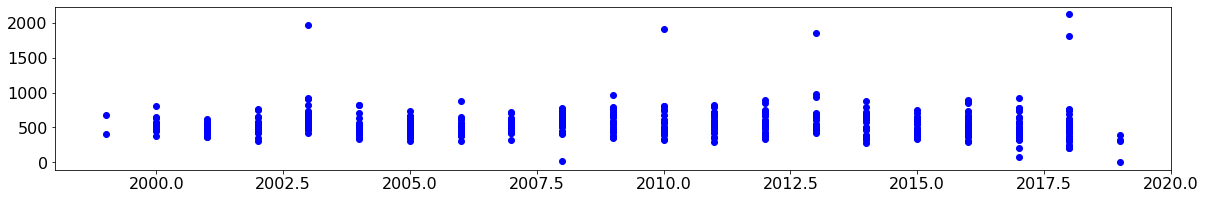

In [34]:
x = year_sorted_songs['year'].values

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,3)
plt.plot(x, back_similarities, 'bo')

plt.show()

### Descrição
Não entendi muito bem como que a comparação entre anos deveria ser feita, então comparei uma música de 2019 com o restante das músicas. Porém esse a partir dessa forma de comparação, não consegui perceber uma decaída ou subida em termos de similaridade.